# Lab 6

You are tasked with evaluating card counting strategies for black jack. In order to do so, you will use object oriented programming to create a playable casino style black jack game where a computer dealer plays against $n$ computer players and possibily one human player. If you don't know the rules of blackjack or card counting, please google it. 

A few requirements:
* The game should utilize multiple 52-card decks. Typically the game is played with 6 decks.
* Players should have chips.
* Dealer's actions are predefined by rules of the game (typically hit on 16). 
* The players should be aware of all shown cards so that they can count cards.
* Each player could have a different strategy.
* The system should allow you to play large numbers of games, study the outcomes, and compare average winnings per hand rate for different strategies.

1. Begin by creating a classes to represent cards and decks. The deck should support more than one 52-card set. The deck should allow you to shuffle and draw cards. Include a "plastic" card, placed randomly in the deck. Later, when the plastic card is dealt, shuffle the cards before the next deal.

2. Now design your game on a UML diagram. You may want to create classes to represent, players, a hand, and/or the game. As you work through the lab, update your UML diagram. At the end of the lab, submit your diagram (as pdf file) along with your notebook. 

3. Begin with implementing the skeleton (ie define data members and methods/functions, but do not code the logic) of the classes in your UML diagram.

4. Complete the implementation by coding the logic of all functions. For now, just implement the dealer player and human player.

5.  Test. Demonstrate game play. For example, create a game of several dealer players and show that the game is functional through several rounds.

6. Implement a new player with the following strategy:

    * Assign each card a value: 
        * Cards 2 to 6 are +1 
        * Cards 7 to 9 are 0 
        * Cards 10 through Ace are -1
    * Compute the sum of the values for all cards seen so far.
    * Hit if sum is very negative, stay if sum is very positive. Select a threshold for hit/stay, e.g. 0 or -2.  

7. Create a test scenario where one player, using the above strategy, is playing with a dealer and 3 other players that follow the dealer's strategy. Each player starts with same number of chips. Play 50 rounds (or until the strategy player is out of money). Compute the strategy player's winnings. You may remove unnecessary printouts from your code (perhaps implement a verbose/quiet mode) to reduce the output.

8. Create a loop that runs 100 games of 50 rounds, as setup in previous question, and store the strategy player's chips at the end of the game (aka "winnings") in a list. Histogram the winnings. What is the average winnings per round? What is the standard deviation. What is the probabilty of net winning or lossing after 50 rounds?


9. Repeat previous questions scanning the value of the threshold. Try at least 5 different threshold values. Can you find an optimal value?

10. Create a new strategy based on web searches or your own ideas. Demonstrate that the new strategy will result in increased or decreased winnings. 

Average winnings after 50 rounds: -2.8
Total winnings after 50 rounds: -140
Average winnings after 211 rounds in 100 games: -58.66824644549763


Text(0.5, 1.0, 'Strategy Player Winnings in Blackjack')

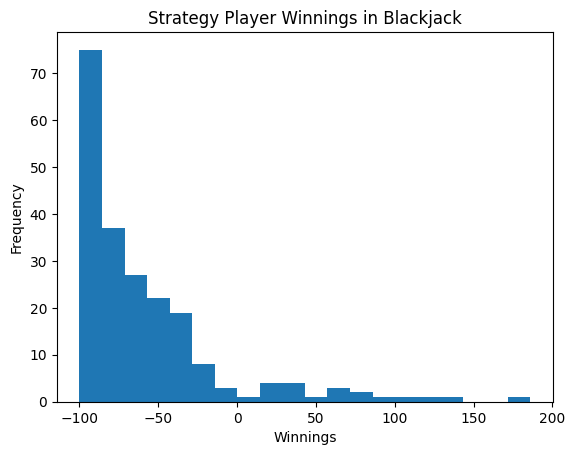

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

class Card:
    def __init__(self, suit, rank):
        self.suit = suit
        self.rank = rank
        self.value = self.get_value()

    def get_value(self):
        if self.rank in ['J', 'Q', 'K']:
            return 10
        elif self.rank == 'A':
            return 11  # Can be adjusted to 1 in gameplay
        else:
            return int(self.rank)

    def __repr__(self):
        return f"{self.rank}{self.suit}"

class Deck:
    suits = ['H', 'D', 'C', 'S']
    ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']

    def __init__(self, num_decks=6):
        self.num_decks = num_decks
        self.cards = self.generate_deck()
        self.shuffle()
        self.plastic_card_position = random.randint(15, len(self.cards) - 15)
    
    def generate_deck(self):
        return [Card(suit, rank) for suit in self.suits for rank in self.ranks] * self.num_decks
    
    def shuffle(self):
        random.shuffle(self.cards)
    
    def draw_card(self):
        if len(self.cards) == self.plastic_card_position:
            self.shuffle()
        return self.cards.pop() if self.cards else None

class Player:
    def __init__(self, name, chips=100, is_human=False):
        self.name = name
        self.chips = chips
        self.hand = []
        self.bet = 0
        self.won = False
        self.is_human = is_human
    
    def place_bet(self, amount):
        if amount <= self.chips:
            self.chips -= amount
            self.bet = amount
            return amount
        if amount > self.chips:
            print(f"{self.name} does not have enough chips to place a bet of {amount}. Placing bet of {self.chips} instead.")
            amount = self.chips
            self.bet = amount
            self.chips = 0
            return amount
        
    def add_money(self, amount):
        self.chips += amount
    
    def receive_card(self, card):
        self.hand.append(card)
    
    def show_hand(self):
        return self.hand

    def hand_value(self):
        value = sum(card.value for card in self.hand)
        num_aces = sum(1 for card in self.hand if card.rank == 'A')
        while value > 21 and num_aces:
            value -= 10
            num_aces -= 1
        return value

    def has_busted(self):
        return self.hand_value() > 21

    def should_hit(self, dealer, players=None):
        if self.is_human:
            while True:
                print("\n--- Your Turn ---")

                print("What would you like to do?")
                choice = input(f"Your hand: {self.show_hand()} (Value: {self.hand_value()}). Dealer's face-up card(s): {dealer.show_hand()[1:]}. Hit or Stay? (h/s): ")
                if choice.lower() in ['h', 's']:
                    return choice.lower() == 'h'
                print("Invalid choice. Please enter 'h' or 's'.")
                
        #Common way to determine if player should hit or stay compared to dealer's face up card(s)
        return self.hand_value() < 17

    def blackjack(self):
        return self.hand_value() == 21 and len(self.hand) == 2
    
    def has_21(self):
        return self.hand_value() == 21

    def payout(self, profit=2):
        self.chips += profit * self.bet
        self.won = True

    def did_win(self):
        return self.won
        
    def print_status(self):
        print(f"{self.name}: {self.show_hand()} (Value: {self.hand_value()}) {'BUSTED' if self.has_busted() else ''}")

class StrategyPlayer(Player):
    def __init__(self):
        super().__init__(name="Strategy Player")

    def should_hit(self, dealer, players):
        shown_cards = dealer.show_hand()[1:]

        for player in players:
                shown_cards += player.show_hand()

        # # Cards 2 to 6 are +1 
        # * Cards 7 to 9 are 0 
        # * Cards 10 through Ace are -1
        total_value = sum( 1 if 2 < card.value <= 6 else 0 if 7 < card.value <=  9 else -1 for card in shown_cards)

        threshold = 0

        # If the total value is less than 0, the player should hit else stay
        return total_value < threshold

class Dealer(Player):
    def __init__(self):
        super().__init__(name="Dealer")
    
    def should_hit(self):
        return self.hand_value() < 17

    def print_status(self, end=False):
        if end:
            super().print_status()
        else:
            print(f"{self.name}: {self.show_hand()[1:]} (Value: {self.shown_cards_value()})")  
    
    def shown_cards_value(self):
        return sum(card.value for card in self.hand[1:])

class BlackjackGame:
    def __init__(self, num_players=1, verbose=True, include_human=False, include_strategy_player=False):
        self.deck = Deck()
        self.dealer = Dealer()
        self.players = [Player(f"Player {i+1}") for i in range(num_players)]
        self.verbose = verbose
        if include_human:
            self.human_player = Player("Human", is_human=True)
            if num_players == 1:
                self.players = [self.human_player]
            else:
                self.players.append(self.human_player)
        else:
            self.human_player = None
        
        if include_strategy_player:
            self.strategy_player = StrategyPlayer()
            self.players.append(self.strategy_player)

        self.num_players = len(self.players)
    
    def winner_or_dealer_bust(self):
        if self.verbose:
            #Print Everyone's hand
            print("\n--- Round Over ---\n")

            print("--- Final Hands ---\n")
            self.dealer.print_status(end=True)

            for player in self.players:
                player.print_status()
            
            print("")

            if self.dealer.has_busted():
                print("Dealer busts! Table wins!")
                for player in self.players:
                    if not player.has_busted():
                        player.chips += 2 * player.bet
            else :
                # Check for player wins and losses
                print("")

                for player in self.players:
                    if player.hand_value() > self.dealer.hand_value() and not player.has_busted():
                        print(f"{player.name} wins!")
                        player.chips += 2 * player.bet
                    elif player.hand_value() == self.dealer.hand_value():
                        print(f"{player.name} pushes!")
                        player.chips += player.bet
                    else:
                        print(f"{player.name} loses!")

                print("")

            for player in self.players:
                print(f"{player.name} has {int(player.chips)} chips.")

    def play_round(self):
        # Clear hands

        for player in self.players:
            player.hand = []
            player.bet = 0
            player.won = False

        self.dealer.hand = []

        if self.verbose:
            print("\n--- New Round ---")

            print("Placing bets...\n")

        for player in self.players:
            if player.is_human:
                print(f"\nWhat is your bet?")
                bet = int(input())
                if bet < 25:
                    print("Minimum bet is 25 chips. Placing bet of 25 chips instead.")
                    if player.chips < 25:
                        print("You are out of chips and cannot place a bet.")
                        print("Would you like to add more chips? (y/n): ")
                        choice = input().lower()
                        
                        while choice not in ['y', 'n']:
                            print("Invalid choice. Please enter 'y' or 'n'.")
                            choice = input().lower()
                        if choice == 'y':
                            print("How many chips would you like to add?")
                            amount = int(input())
                            player.add_money(amount)
                            player.place_bet(25)
                    else:
                        player.place_bet(25)                            
                player.place_bet(bet)
            else: 
                try:
                    player.place_bet(random.randint(25,  player.chips))
                except Exception as e:
                    if type(player) == StrategyPlayer:
                        if self.verbose:
                            print("Strategy player is out of chips and cannot place a bet.")
                            print("Ending game.")
                        return -1
                    if self.verbose:
                        print("Minimum bet is 25 chips.")
                        print(f"{player.name} cannot place a bet.")
                    continue
            if self.verbose:
                print(f"{player.name} placed a bet of {player.bet}.")
        if self.verbose:
            print("\nDealing cards...\n")

        for player in self.players:
            if player.bet != 0:
                player.receive_card(self.deck.draw_card())
                player.receive_card(self.deck.draw_card())
        self.dealer.receive_card(self.deck.draw_card())

        dealer_face_up_card = self.deck.draw_card()
        self.dealer.receive_card(dealer_face_up_card)
        if self.verbose:
            print("--- Game status ---\n")

            print(f"\nDealer's face-up card: {dealer_face_up_card}")

        # Print player status
        if self.verbose:
            for player in self.players:
                player.print_status()
        
            print("")

        if self.verbose:
            #Check for dealer blackjack
            if self.dealer.blackjack():
                print("Dealer has blackjack! Table loses!")
                return
        if self.verbose:
            # Check for player blackjack
            for player in self.players:
                if player.blackjack():
                    print(f"{player.name} has blackjack!")
                    player.payout(profit=2.5)

        for player in self.players:
            while not player.did_win() and not player.has_busted() and player.bet != 0:
                if player.should_hit(self.dealer, self.players) and not player.has_busted():
                    player.receive_card(self.deck.draw_card())
                    if self.verbose:
                        print(f"{player.name} hits.")
                        player.print_status()

                    if player.hand_value() == 21:
                        if self.verbose:
                            print(f"{player.name} wins, they have 21!")
                        player.payout()
                        return

                else:
                    if self.verbose:
                        print(f"{player.name} stays.")
                        player.print_status()
                    break
                if player.has_busted():
                    if self.verbose:
                        print(f"{player.name} busts.")
                        if self.num_players == 1:
                            print("\nYou lose!")
                            print(f"Your chips is now: {player.chips}")
                        return
                if self.verbose:
                    print("")

        # Dealer's turn
        if self.verbose:
            print("\nDealer's turn...\n")

        while self.dealer.should_hit() and not self.dealer.has_busted():
            self.dealer.receive_card(self.deck.draw_card())
            if self.verbose:
                print("Dealer hits.")
                self.dealer.print_status()
        if self.verbose:
            if not self.dealer.has_busted():
                print("Dealer stays.")
        
        if self.dealer.has_21():
            if self.verbose:
                print("Dealer has 21! Table loses!")
            
                # Print final hands 
                print("\n--- Final Hands ---\n")
                self.dealer.print_status(end=True)

                for player in self.players:
                    player.print_status()
        else:
            self.winner_or_dealer_bust()
            if self.verbose:
                print("\nEnd of round.\n")

        return 0
    
    def compute_strategy_player_winnings(self):
        for player in self.players:
            if isinstance(player, StrategyPlayer):
                return player.chips - 100  # Initial chips were 100
        return 0
        
    

# # Run a playable game with a human player and dealer
# while True:

#     game = BlackjackGame(num_players=1, include_human=True)
#     game.play_round()

#     print("\nWould you like to play another round? (y/n): ")
#     choice = input().lower()
#     while choice not in ['y', 'n']:
#         print("Invalid choice. Please enter 'y' or 'n'.")
#         choice = input().lower()

#     if choice.lower() == 'n':
#         break

# print("\nThanks for playing!")

# 7. 50 rounds
total_winnings = []
rounds_played = 0

print("When playing maximum of 50 rounds here are the results: ")

game = BlackjackGame(num_players=3, verbose=False, include_strategy_player=True)

for j in range(50):
    val = game.play_round()
    if val == -1:
        break
    rounds_played += 1

    total_winnings.append(game.compute_strategy_player_winnings())

print(f"Average winnings after 50 rounds: {sum(total_winnings) / 50}")
print(f"Total winnings after 50 rounds: {sum(total_winnings)}")


print("When playing a total of 100 games with maximum 50 rounds each: ")

total_winnings = []
num_games = 100
rounds_played = 0

for i in range(num_games):

    game = BlackjackGame(num_players=3, verbose=False, include_strategy_player=True)

    for j in range(50):
        val = game.play_round()
        if val == -1:
            break
        rounds_played += 1
        total_winnings.append(game.compute_strategy_player_winnings())

average_winnings = sum(total_winnings) / rounds_played
print(f"Average winnings after {rounds_played} rounds in 100 games: {average_winnings}")
# Histogram of strategy player winnings

plt.hist(total_winnings, bins=20)
plt.xlabel("Winnings")
plt.ylabel("Frequency")
plt.title("Strategy Player Winnings in Blackjack")

